# GNN 


Code based on 

https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=zF5bw3m9UrMy

In [1]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import random
from math import floor
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import time



c:\Users\markm\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Import data
X = pd.read_csv('./Data/df_X_gnn.csv')
y = pd.read_csv('./Data/df_y_gnn.csv')
edge_idx = pd.read_csv('./Data/df_e_idx_gnn.csv')

edge_att = pd.read_csv('./Data/df_e_att_gnn.csv')

X = X.to_numpy()
y = y.to_numpy()
y = y[:,0]



X = torch.tensor(X).float()
y = torch.tensor(y).float()
edge_idx = torch.tensor(edge_idx.to_numpy()).int()
edge_att = torch.tensor(edge_att.to_numpy()).float()

#edge_idx = edge_idx.transpose(0,1)

edge_idx.size()

torch.Size([2, 1250])

In [16]:
# make masks
n = X.shape[0]
randomassort = list(range(n))
random.shuffle(randomassort)

# percentage of training mask
train_perc = 0.1
max_train = floor(len(randomassort) * train_perc)
train_mask_idx = torch.tensor(randomassort[:max_train])
test_mask_idx = torch.tensor(randomassort[max_train:])
train_mask = torch.zeros(n); test_mask = torch.zeros(n)
train_mask.scatter_(0, train_mask_idx, 1)
test_mask.scatter_(0, test_mask_idx, 1)
train_mask = train_mask.type(torch.bool)
test_mask = test_mask.type(torch.bool)

In [17]:
data = Data(x = X, y = y, edge_index = edge_idx)#, edge_attr = edge_att)

data.test_mask = test_mask
data.train_mask = train_mask
print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Data(x=[297, 10], edge_index=[2, 1250], y=[297], test_mask=[297], train_mask=[297])
Number of nodes: 297
Number of edges: 1250
Average node degree: 4.21
Number of training nodes: 29
Training node label rate: 0.10
Has isolated nodes: True


In [18]:
data.x

tensor([[5.6059e+04, 4.1172e+04, 5.0984e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.6059e+04, 4.1172e+04, 6.4998e+05,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.6059e+04, 4.1172e+04, 1.3588e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.6059e+04, 4.1172e+04, 4.1386e+04,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [5.6059e+04, 4.1172e+04, 4.9018e+04,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        [5.6059e+04, 4.1172e+04, 3.5275e+04,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00]])

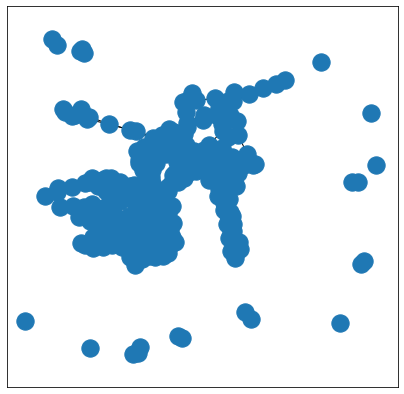

In [19]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, with_labels=False)#, pos=nx.spring_layout(G, seed=42)),
                     #node_color=color, cmap="Set2")
    plt.show()
    
    
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()


G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [20]:

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.pred = Linear(2, 1)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.pred(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(10, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (pred): Linear(in_features=2, out_features=1, bias=True)
)


In [21]:

model = GCN()

criterion = torch.nn.MSELoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Define optimizer.


def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    
    loss, h = train(data)
    print(epoch, loss)
    if epoch % 10 == 0:
        #visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        print(loss)
        time.sleep(0.3)

0 tensor(3442861., grad_fn=<MseLossBackward0>)
tensor(3442861., grad_fn=<MseLossBackward0>)


c:\Users\markm\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1 tensor(3442851.2500, grad_fn=<MseLossBackward0>)
2 tensor(3442841.7500, grad_fn=<MseLossBackward0>)
3 tensor(3442832., grad_fn=<MseLossBackward0>)
4 tensor(3442822.2500, grad_fn=<MseLossBackward0>)
5 tensor(3442812.5000, grad_fn=<MseLossBackward0>)
6 tensor(3442803., grad_fn=<MseLossBackward0>)
7 tensor(3442793., grad_fn=<MseLossBackward0>)
8 tensor(3442783.2500, grad_fn=<MseLossBackward0>)
9 tensor(3442773.7500, grad_fn=<MseLossBackward0>)
10 tensor(3442764., grad_fn=<MseLossBackward0>)
tensor(3442764., grad_fn=<MseLossBackward0>)
11 tensor(3442754., grad_fn=<MseLossBackward0>)
12 tensor(3442744.5000, grad_fn=<MseLossBackward0>)
13 tensor(3442735., grad_fn=<MseLossBackward0>)
14 tensor(3442725.2500, grad_fn=<MseLossBackward0>)
15 tensor(3442715.5000, grad_fn=<MseLossBackward0>)
16 tensor(3442705.7500, grad_fn=<MseLossBackward0>)
17 tensor(3442696., grad_fn=<MseLossBackward0>)
18 tensor(3442686.2500, grad_fn=<MseLossBackward0>)
19 tensor(3442676.5000, grad_fn=<MseLossBackward0>)
20 t